In [2]:
import numpy as np
import pandas as pd
import string
import random
import os
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras import backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras import utils

import sklearn
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle

import pymystem3
from pymystem3 import Mystem

In [3]:
print("pandas version: ", pd.__version__)
print("numpy version: ", np.__version__)
print("sklearn version: ", sklearn.__version__)
print("pymystem3 version: ", pymystem3.__version__)

pandas version:  1.2.2
numpy version:  1.19.5
sklearn version:  0.23.2
pymystem3 version:  0.2.0


In [4]:
seed=42    
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' # вычисления на GPU

In [5]:
# кастоиная функции f-меры
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
def RemovePunctuation(text):
    if str(text)!='nan':
        text = text.lower()
        translator = str.maketrans('', '', string.punctuation)
        return text.translate(translator)
    else:
        return text

In [6]:
train = pd.read_csv('train.csv')
target_typology = train['typology'].unique().tolist()
train_url_only = pd.read_csv("train_url_only.csv").drop(columns='url')

In [7]:
train = pd.concat([train, train_url_only]).query("description.notnull()", engine='python')

In [8]:
#фильтрую нужный таргет
train['is_train_target'] = train['typology'].apply(lambda x: 1 if x in target_typology else 0)
train = train.query('is_train_target==1').reset_index(drop=True)

In [9]:
#train = pd.read_csv('train_for_text.csv')
#train['description'] = train['description'].apply(lambda x: RemovePunctuation(x)) 

In [10]:
train['description'] = train['description'].apply(lambda x: RemovePunctuation(x)) 

In [11]:
train, valid = train_test_split(train, test_size = 0.1, stratify = train['typology'], random_state=seed)

In [19]:
max_len = 80
embed_dim = 100
docs = train['description'].tolist()
tokenizer = Tokenizer(num_words=None, char_level=False)

In [20]:
tokenizer.fit_on_texts(docs)
word_index = tokenizer.word_index

In [47]:
# сохраняем tokenizer для инференс 
with open('Models_text/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
X_train = tokenizer.texts_to_sequences(train['description'].tolist())
X_train = sequence.pad_sequences(X_train, maxlen=max_len, padding='post')

In [35]:
train_labels = train['typology'].tolist()
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
train_labels = utils.to_categorical(train_labels, 15)

In [46]:
# сохраняем LabelEncoder для инференс
with open('Models_text/LabelEncoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
#Loading pre-trained embeddings
embeddings_index = {}
f = open('Models_text/w2v.vec')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 46139 word vectors.


In [40]:
#At this point we can leverage our embedding_index dictionary and our word_index to compute our embedding matrix
hits = 0
misses = 0
embedding_matrix = np.zeros((len(word_index)+1, embed_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 46114 words (130956 misses)


In [37]:
#Helpers
folds = 10
es = EarlyStopping(monitor='val_f1_m', mode='max', 
                       patience=3, restore_best_weights=True, verbose=1)
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

In [40]:
#Architecture NN
def architecture_NN():
    inp = L.Input(shape=(max_len,), dtype="int64")
    embedding_layer = L.Embedding(len(word_index)+1, embed_dim, input_length=max_len, weights=[embedding_matrix],trainable=False)(inp)
    bilstm = L.Bidirectional(L.LSTM(128, return_sequences=True, dropout=0.2))(embedding_layer)
    bilstm = L.Bidirectional(L.LSTM(64, return_sequences=True, dropout=0.1))(bilstm)
    bilstm = L.Bidirectional(L.LSTM(32, return_sequences=False, dropout=0.1))(bilstm)
    flat = L.Flatten()(bilstm)
    #x = L.Dense(50, activation = 'relu', kernel_initializer='he_uniform', bias_initializer='zeros')(flat)
    x = L.BatchNormalization()(flat)
    out = L.Dense(15, activation = 'softmax', kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    model = tf.keras.models.Model(inputs = inp, outputs = out)
    return model

In [41]:
architecture_NN().summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 80, 100)           17707100  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 80, 256)           234496    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 80, 128)           164352    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256 

In [42]:
LR = 0.0005
batch_size = 32
num_epochs = 50

время обучения на 3070 около 4 часов

In [43]:
start_time = time.time()
history_list = []
models_list = []
for fold, (idxT, idxV) in enumerate(skf.split(X_train, train['typology'].tolist())):
    K.clear_session()
    model = architecture_NN()
    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(LR), metrics=[f1_m])
    history = model.fit(X_train[idxT], train_labels[idxT],
                    batch_size=batch_size,
                    epochs=num_epochs, 
                    validation_data=(X_train[idxV], train_labels[idxV]),
                    callbacks=[es],
                    verbose=1)
    history_list.append(history.history)
    models_list.append(model)
    model.save(f"Models_text/model_text_fold_{fold}.h5")
print(f"hours: {(time.time()-start_time)/3600}")

Epoch 1/50
5110/5110 [==============================] - 89s 17ms/step - loss: 0.9555 - f1_m: 0.6821 - val_loss: 0.6691 - val_f1_m: 0.7861
Epoch 2/50
5110/5110 [==============================] - 84s 16ms/step - loss: 0.6749 - f1_m: 0.7826 - val_loss: 0.6185 - val_f1_m: 0.8056
Epoch 3/50
5110/5110 [==============================] - 85s 17ms/step - loss: 0.6224 - f1_m: 0.7989 - val_loss: 0.6534 - val_f1_m: 0.7995
Epoch 4/50
5110/5110 [==============================] - 82s 16ms/step - loss: 0.5836 - f1_m: 0.8108 - val_loss: 0.5800 - val_f1_m: 0.8182
Epoch 5/50
5110/5110 [==============================] - 81s 16ms/step - loss: 0.5622 - f1_m: 0.8196 - val_loss: 0.5760 - val_f1_m: 0.8194
Epoch 6/50
5110/5110 [==============================] - 82s 16ms/step - loss: 0.5384 - f1_m: 0.8252 - val_loss: 0.5600 - val_f1_m: 0.8278
Epoch 7/50
5110/5110 [==============================] - 80s 16ms/step - loss: 0.5184 - f1_m: 0.8335 - val_loss: 0.5557 - val_f1_m: 0.8278
Epoch 8/50
5110/5110 [============

5110/5110 [==============================] - 81s 16ms/step - loss: 0.4595 - f1_m: 0.8511 - val_loss: 0.5400 - val_f1_m: 0.8329
Epoch 13/50
5110/5110 [==============================] - 81s 16ms/step - loss: 0.4586 - f1_m: 0.8513 - val_loss: 0.5481 - val_f1_m: 0.8302
Epoch 14/50
5110/5110 [==============================] - 81s 16ms/step - loss: 0.4523 - f1_m: 0.8527 - val_loss: 0.5517 - val_f1_m: 0.8305
Epoch 15/50
5110/5110 [==============================] - 80s 16ms/step - loss: 0.4443 - f1_m: 0.8553 - val_loss: 0.5470 - val_f1_m: 0.8348
Epoch 16/50
5110/5110 [==============================] - 84s 16ms/step - loss: 0.4408 - f1_m: 0.8568 - val_loss: 0.5462 - val_f1_m: 0.8334
Epoch 17/50
5110/5110 [==============================] - 79s 16ms/step - loss: 0.4233 - f1_m: 0.8624 - val_loss: 0.5565 - val_f1_m: 0.8315
Epoch 18/50
5110/5110 [==============================] - 81s 16ms/step - loss: 0.4201 - f1_m: 0.8643 - val_loss: 0.5476 - val_f1_m: 0.8340
Restoring model weights from the end of

In [44]:
def plot_hist(history):
    plt.plot(history['f1_m'])
    plt.plot(history['val_f1_m'])
    plt.show()

f1 for fold 1


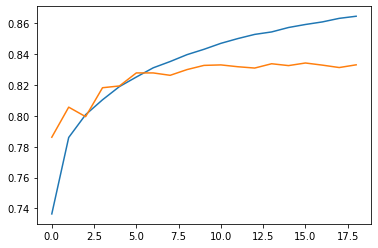

f1 for fold 2


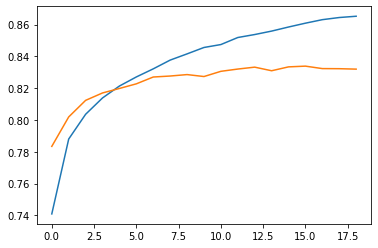

f1 for fold 3


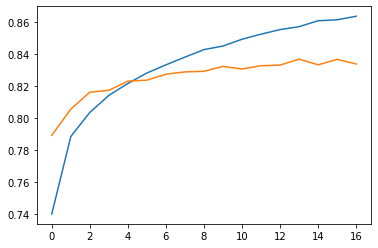

f1 for fold 4


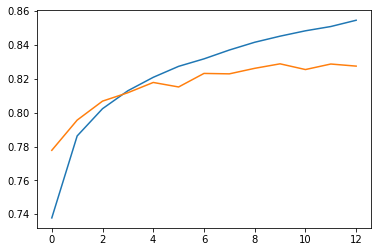

f1 for fold 5


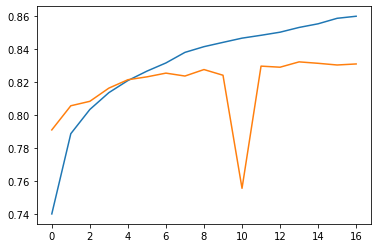

f1 for fold 6


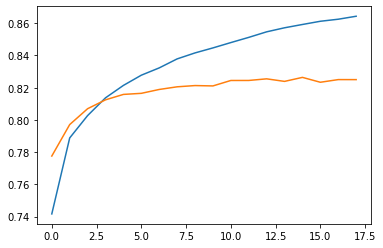

f1 for fold 7


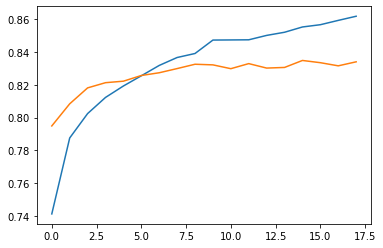

f1 for fold 8


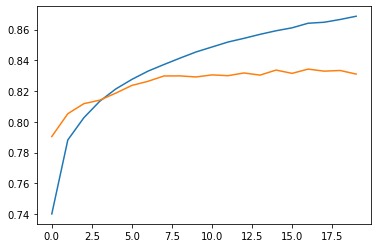

f1 for fold 9


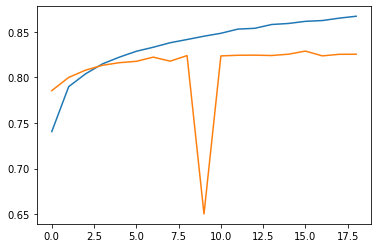

f1 for fold 10


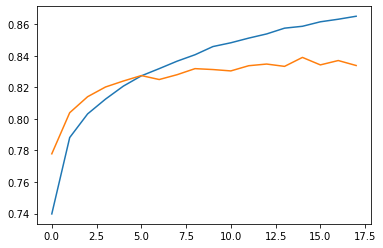

In [45]:
for fold, hist in enumerate(history_list):
    print(f"f1 for fold {fold+1}")
    plot_hist(hist)

###### анализ результатов

In [13]:
valid.head()

,guid,description,typology,is_train_target
32818,9047d760-96e3-4a44-aa37-efce65f2c106,письмо открытое самара александроневскiй кафед...,предметы печатной продукции,1
129308,4ff1a9cb-38ec-46b9-90b8-255f55df3898,крестэнколпион распятие св николай избранные с...,"предметы прикладного искусства, быта и этнографии",1
101241,e4816cec-70a6-44cf-b998-153308083bf4,изразец,"предметы прикладного искусства, быта и этнографии",1
31541,aaf61ceb-f9ad-4e96-a6c4-111cd79620a0,медаль 40 лет победы в великой отечественной в...,предметы нумизматики,1
7117,15051108-d1de-4e56-a59e-d693b2e14eb6,фотография портрет писателя аабсалямова,фотографии и негативы,1


In [13]:
with open('Models_text/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [14]:
X_valid = tokenizer.texts_to_sequences(valid[valid['description'].notnull()==True]['description'].tolist())

In [16]:
X_valid = sequence.pad_sequences(X_valid, maxlen=max_len, padding='post')

In [18]:
predicts = list()
for item in os.listdir("Models_text/"):
    if item.endswith(".h5"):
        print(f"Models_text/{item}")
        model = tf.keras.models.load_model(f"Models_text/{item}", custom_objects={'f1_m': f1_m})
        predicts.append(model.predict(X_valid))

Models_text/model_text_fold_0.h5
Models_text/model_text_fold_1.h5
Models_text/model_text_fold_2.h5
Models_text/model_text_fold_3.h5
Models_text/model_text_fold_4.h5
Models_text/model_text_fold_5.h5
Models_text/model_text_fold_6.h5
Models_text/model_text_fold_7.h5
Models_text/model_text_fold_8.h5
Models_text/model_text_fold_9.h5


In [25]:
with open('Models_text/LabelEncoder.pickle', 'rb') as handle:
    le = pickle.load(handle)

In [36]:
valid['typology_predict'] = le.inverse_transform(np.argmax(np.array(predicts).mean(axis=0), axis=1))

In [40]:
valid.to_csv('valid_temp.csv', index = False)

In [12]:
valid = pd.read_csv("valid_temp.csv")

In [13]:
valid.head()

,guid,description,typology,is_train_target,typology_predict
0,9047d760-96e3-4a44-aa37-efce65f2c106,письмо открытое самара александроневскiй кафед...,предметы печатной продукции,1,предметы печатной продукции
1,4ff1a9cb-38ec-46b9-90b8-255f55df3898,крестэнколпион распятие св николай избранные с...,"предметы прикладного искусства, быта и этнографии",1,"предметы прикладного искусства, быта и этнографии"
2,e4816cec-70a6-44cf-b998-153308083bf4,изразец,"предметы прикладного искусства, быта и этнографии",1,"предметы прикладного искусства, быта и этнографии"
3,aaf61ceb-f9ad-4e96-a6c4-111cd79620a0,медаль 40 лет победы в великой отечественной в...,предметы нумизматики,1,предметы нумизматики
4,15051108-d1de-4e56-a59e-d693b2e14eb6,фотография портрет писателя аабсалямова,фотографии и негативы,1,фотографии и негативы


In [14]:
from sklearn.metrics import f1_score
f1_score(valid['typology'], valid['typology_predict'], average='macro')

0.7584868536156736

In [15]:
import sklearn.metrics
for i in valid['typology'].unique():
    print(i)
    print(sklearn.metrics.accuracy_score(valid.query(f"typology=='{i}'")['typology'], valid.query(f"typology=='{i}'")['typology_predict']))

предметы печатной продукции
0.7264106211474632
предметы прикладного искусства, быта и этнографии
0.9029945170814002
предметы нумизматики
0.9719387755102041
фотографии и негативы
0.9326322707854091
предметы естественнонаучной коллекции
0.9013157894736842
прочие
0.31067044381491976
предметы археологии
0.9464285714285714
живопись
0.5989010989010989
документы
0.8721153846153846
редкие книги
0.8286052009456265
графика
0.8125802310654685
оружие
0.7469879518072289
предметы техники
0.5253164556962026
скульптура
0.2807017543859649
предметы минералогической коллекции
0.7671232876712328


In [22]:
cm = confusion_matrix(valid['typology'], valid['typology_predict'])

In [ ]:
cm.

In [30]:
from sklearn.metrics import confusion_matrix
cm_df = pd.DataFrame(cm,
                     index = le.classes_.tolist(), 
                     columns = le.classes_.tolist())

In [31]:
cm_df

,графика,документы,живопись,оружие,предметы археологии,предметы естественнонаучной коллекции,предметы минералогической коллекции,предметы нумизматики,предметы печатной продукции,"предметы прикладного искусства, быта и этнографии",предметы техники,прочие,редкие книги,скульптура,фотографии и негативы
графика,1266,32,35,0,1,1,0,2,102,63,0,6,8,0,42
документы,38,2721,1,0,1,1,0,10,146,12,2,29,33,0,126
живопись,104,8,218,0,1,2,0,0,4,18,0,0,0,0,9
оружие,0,0,0,62,7,0,0,0,0,12,0,2,0,0,0
предметы археологии,4,0,2,4,2332,4,1,18,2,95,1,1,0,0,0
предметы естественнонаучной коллекции,3,0,0,0,11,411,15,0,0,11,0,1,1,1,2
предметы минералогической коллекции,1,1,0,0,5,8,112,0,3,16,0,0,0,0,0
предметы нумизматики,5,7,0,0,9,0,1,2286,34,4,0,4,0,0,2
предметы печатной продукции,99,152,2,0,1,1,0,27,1532,19,1,13,210,1,51
"предметы прикладного искусства, быта и этнографии",17,14,14,5,92,4,0,13,10,2141,17,33,1,7,3


In [16]:
valid['typology'].value_counts()

документы                                            3120
фотографии и негативы                                3043
предметы археологии                                  2464
предметы прикладного искусства, быта и этнографии    2371
предметы нумизматики                                 2352
предметы печатной продукции                          2109
графика                                              1558
прочие                                               1059
редкие книги                                          846
предметы естественнонаучной коллекции                 456
живопись                                              364
предметы техники                                      158
предметы минералогической коллекции                   146
оружие                                                 83
скульптура                                             57
Name: typology, dtype: int64